In [56]:
#Load necessary libraries
import json 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import time
import warnings
from bs4 import BeautifulSoup
from geopy import distance
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv, enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

In [59]:
API_KEY = ''

In [3]:
properties = []
properties_list = []
amenities_dfs_lst = []
base_url = 'https://www.buyrentkenya.com'

#Loop through all pages containing properties

for i in range(1,69):
    if i == 1:
        url = base_url + '/houses-for-sale/nairobi'
    else:
        url = f'{base_url}/houses-for-sale/nairobi?page={i}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    houses = soup.find_all('div', {'class': 'flex flex-col items-stretch md:flex-row'})
    for house in houses:
        #Grab all available details per house
        #Grab name
        if house.find('h3', {'class': 'hide-title text-black text-base leading-normal mb-1 capitalize font-normal'}) == None:
            name = ''.strip()
        else:
            name = house.find('h3', {'class': 'hide-title text-black text-base leading-normal mb-1 capitalize font-normal'}).text.strip()
        
        #Grab price
        if house.find('p', {'class': 'text-primary font-semibold mr-5 text-lg'}) == None:
            price = ''
        else:
            price = house.find('p', {'class': 'text-primary font-semibold mr-5 text-lg'}).text
        
        #Grab location
        if house.find('p', {'class': 'text-md md:text-sm font-normal text-grey-darker mt-1 md:mt-0'}) == None:
            location = ''
        else:
            location = house.find('p', {'class': 'text-md md:text-sm font-normal text-grey-darker mt-1 md:mt-0'}).text
        
        #Grab area/size
        if house.find('span', {'data-cy': 'card-area'}) == None:
            area = ''
        else:
            area = house.find('span', {'data-cy': 'card-area'}).text
        
        #Grab no. of bedrooms
        if house.find('span', {'data-cy': 'card-beds'}) == None:
            bedrooms = ''
        else:
            bedrooms = house.find('span', {'data-cy': 'card-beds'}).text
        
        #Grab no. of bathrooms
        if house.find('div', {'data-cy': 'card-baths'}) == None:
            bathrooms = ''
        else:
            bathrooms = house.find('div', {'data-cy': 'card-baths'}).text
        
        #Create a dictionary with property details
        property_details = {'Name': name, 'Price': price, 'Location': location, 
                            'Area': area, 'Bedrooms': bedrooms, 'Bathrooms': bathrooms}

        #Append the dictionary created above to the empty list initialized on top
        properties.append(property_details)
        
        #Click on property to access next page with full property details
        #Fetch next page link 'a-href'
        next_page_link = house.find('a')
        extract_link = next_page_link.get('href')
        
        #Concatenate next page link to the base url and create soup object
        next_pg_url = base_url+extract_link
        next_pg_response = requests.get(next_pg_url)
        next_pg_soup = BeautifulSoup(next_pg_response.content, 'html.parser')
        
        #Locate table containing property amenities
        amenities = next_pg_soup.find_all('div', {'class': 'flex-auto lg:mr-12 text-sm overflow-hidden break-words'})
        
        amenities_lst = []
        
        #Loop through the amenities available
        for amenity in amenities:
            amenity = amenity.text.strip()
            
            #Create dictionary with a value of 1 for each available amenity and append dict in list
            amenity_dict = {amenity: 1}
            amenities_lst.append(amenity_dict)
        #Create a mega dictionary with all dictionaries in the  amenities_lst list
        amenities_dict = {key: value for d in amenities_lst for key, value in d.items()}
        
        #Dump the dictionary into a pandas dataframe
        amenity_df = pd.DataFrame(amenities_dict, index=[0], dtype='string')
        
        #Add new column for property name and set column as index - to help with merging later on 
        amenity_df['Name'] = name
        amenity_df = amenity_df.set_index('Name')
        
        #Append the dataframe to the initialized empty list
        amenities_dfs_lst.append(amenity_df)
    time.sleep(3)

#Create mega list using all property dictionaries in the properties list
properties_list = [{key: value.strip() for key, value in properti.items()} for properti in properties]

In [4]:
#Create a pandas dataframe using the mega list with property details from the main page
property_df = pd.DataFrame(properties_list)

#Set the index column to help with merging later on
property_df.set_index('Name')
property_df.head()

,Name,Price,Location,Area,Bedrooms,Bathrooms
0,4 Bed House with Garage at Hendred Road / Mbaa...,"KSh 25,000,000","Gitanga, Hendred Road / Mbaazi Avenue, Lavington",,4,3
1,4 Bed Villa with Garage in Kiambu Road,"KSh 30,000,000",Kiambu Road,,4,4
2,5 Bed House with Garage in Kitisuru,"KSh 85,000,000","Kitisuru, Westlands",,5,5
3,4 Bed Townhouse with Swimming Pool at Loresho,"KSh 45,000,000","Loresho, Westlands",232 m²,4,5
4,4 Bed House with Garage in Karen,"KSh 85,000,000",Karen,,4,4


In [5]:
#Create a pandas dataframe using the mega list with amenities available from the second -amenities- page
amenities_df = pd.concat(amenities_dfs_lst, axis=0, ignore_index=False)
amenities_df


,School,Bus Stop,Hospital,Balcony,Parking,Staff Quarters,Electric Fence,Garden,Furnished,En Suite,...,Shopping Centre,Borehole,Swimming Pool,Wheelchair Access,Aircon,Alarm,Gym,Fibre Internet,Sea View,Service Charge Included
Name,,,,,,,,,,,,,,,,,,,,,
4 Bed House with Garage at Hendred Road / Mbaazi Avenue,1,1,1,1,1,1,1,1,1,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4 Bed Villa with Garage in Kiambu Road,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5 Bed House with Garage in Kitisuru,<NA>,1,1,1,1,1,1,1,<NA>,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4 Bed Townhouse with Swimming Pool at Loresho,1,1,1,1,1,1,1,1,<NA>,1,...,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>
4 Bed House with Garage in Karen,1,<NA>,1,1,1,1,1,1,<NA>,1,...,<NA>,1,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4 Bed Townhouse with Garage at Njumbi Rd,1,<NA>,1,<NA>,1,1,1,1,<NA>,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,1,<NA>,<NA>
4 Bed House with Garage at Karen,1,1,1,<NA>,1,1,<NA>,1,<NA>,1,...,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>
6 Bed House with Garage in Karen,1,1,1,1,1,1,<NA>,1,<NA>,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [6]:
#The dataframe only had 1s - fill NaNs with 0 to indicate that amenity is absent for said property
amenities_df = amenities_df.fillna(str(0))
amenities_df.head()

,School,Bus Stop,Hospital,Balcony,Parking,Staff Quarters,Electric Fence,Garden,Furnished,En Suite,...,Shopping Centre,Borehole,Swimming Pool,Wheelchair Access,Aircon,Alarm,Gym,Fibre Internet,Sea View,Service Charge Included
Name,,,,,,,,,,,,,,,,,,,,,
4 Bed House with Garage at Hendred Road / Mbaazi Avenue,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4 Bed Villa with Garage in Kiambu Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5 Bed House with Garage in Kitisuru,0,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4 Bed Townhouse with Swimming Pool at Loresho,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0,0,0
4 Bed House with Garage in Karen,1,0,1,1,1,1,1,1,0,1,...,0,1,0,0,0,1,0,0,0,0


In [7]:
#Merge the two dataframes - properties and amenities - on their index column
df = pd.merge(property_df, amenities_df, on='Name')

In [9]:
lat_long_pairs = []

def get_location_coordinates(location):
    """
    Function to retrive the latitude and longitude of a location/address from 
    Google's Place API
    
    Returns a tuple containing a location's latitude and longitude
    """
    url = f'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input={location}&inputtype=textquery&fields=geometry&key={API_KEY}'
    response = requests.get(url)
    json_response = response.json()
    
    #Exception for when the API does not return expected output
    try: 
        lat =  json_response['candidates'][0]['geometry']['location']['lat']
        lng = json_response['candidates'][0]['geometry']['location']['lng']
    except IndexError:
        lat = ''
        lng = ''
    return (lat, lng)

#Loop through all locations in the dataframe, get and append their coordinates in a list
for location in df['Location']:
    lat_long_pairs.append(get_location_coordinates(location))
lat_long_pairs[12]

(-1.1307381, 36.7648591)

In [10]:
#Obtain latitudes and longitudes from the list created that contains tuples
latitudes = [lat[0] for lat in lat_long_pairs]
longitudes = [long[1] for long in lat_long_pairs]

#Create two new columns in dataframe containing latitudes and longitudes
df['Latitude'] = latitudes
df['Longitude'] = longitudes
df.head()

,Name,Price,Location,Area,Bedrooms,Bathrooms,School,Bus Stop,Hospital,Balcony,...,Swimming Pool,Wheelchair Access,Aircon,Alarm,Gym,Fibre Internet,Sea View,Service Charge Included,Latitude,Longitude
0,4 Bed House with Garage at Hendred Road / Mbaa...,"KSh 25,000,000","Gitanga, Hendred Road / Mbaazi Avenue, Lavington",,4,3,1,1,1,1,...,0,0,0,0,0,0,0,0,-1.292606,36.766757
1,4 Bed Villa with Garage in Kiambu Road,"KSh 30,000,000",Kiambu Road,,4,4,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.130738,36.764859
2,4 Bed Villa with Garage in Kiambu Road,"KSh 30,000,000",Kiambu Road,,4,4,0,0,0,1,...,0,0,0,0,0,1,0,0,-1.130738,36.764859
3,4 Bed Villa with Garage in Kiambu Road,"KSh 30,000,000",Kiambu Road,,4,4,1,1,1,0,...,0,1,0,0,0,1,0,0,-1.130738,36.764859
4,4 Bed Villa with Garage in Kiambu Road,"KSh 30,000,000",Kiambu Road,,4,4,1,1,1,1,...,0,0,0,0,0,0,0,0,-1.130738,36.764859


In [11]:
#Cleaning the data
#Drop duplicated rows if the columns in the list are an exact match
df = df.drop_duplicates(subset=['Name', 'Price', 'Location', 'Area', 'Bedrooms', 'Bathrooms'])

#Format price column to numeric type by removing the currency prefix and whitespace
df['Price'] = df['Price'].str.replace('KSh ', '')
df['Price'] = df['Price'].str.replace(',', '')
df = df[df['Price'].astype(str).str.isnumeric()==True]

#Standardize the Area column from square feet and acres to square metres
sq_ft_2_sq_m = 0.092903
acre_2_sq_m = 4046.86
area_size = []
for size in df['Area']:
    if 'ft²' in str(size):
        size = size.replace(' ft²', '')
        size = float(size) * sq_ft_2_sq_m
        area_size.append(size)
    elif 'm²' in str(size):
        size = size.replace(' m²', '')
        size = float(size) * 1
        area_size.append(size)
    elif 'ac' in str(size):
        size = size.replace(' ac', '')
        size = float(size) * acre_2_sq_m
        area_size.append(size)
    else:
        area_size.append(np.nan)
df['Area_SQM'] = area_size
#Save dataframe to CSV for onward retrieval and processing 
df.to_csv('/users/solomonmuthui/desktop/real_estate_data.csv')

In [12]:
#Read saved dataframe
data = pd.read_csv('/users/solomonmuthui/desktop/real_estate_data.csv')

#Drop columns that are no longer needed for processing 
data = data.drop(columns=['Name', 'Location', 'Area'])

#Replace blank cells in dataframe with NaN
data = data.replace('', np.nan)

#Convert dataframe to float
data = data.astype('float64')
data = round(data, 6)

#Percentage of NaN values per column in the dataframe
(data.isna().sum()/len(data) * 100).sort_values(ascending=False)

Area_SQM                   73.247779
Bathrooms                  13.326752
Longitude                   0.296150
Latitude                    0.296150
Aircon                      0.000000
Golf Course                 0.000000
Shopping Centre             0.000000
Borehole                    0.000000
Swimming Pool               0.000000
Wheelchair Access           0.000000
Gym                         0.000000
Alarm                       0.000000
Walk In Closet              0.000000
Fibre Internet              0.000000
Sea View                    0.000000
Service Charge Included     0.000000
Backup Generator            0.000000
Unnamed: 0                  0.000000
Price                       0.000000
CCTV                        0.000000
Scenic View                 0.000000
Serviced                    0.000000
En Suite                    0.000000
Furnished                   0.000000
Garden                      0.000000
Electric Fence              0.000000
Staff Quarters              0.000000
P

Area in SQM has >70% missing values. Traditional imputation methods, such as KNN imputer, iterative imputer, and even regression, could not yield satisfactory results. See below script.

In [14]:
#Imputation for missing values in Area column
# imputer_KNN = KNNImputer(n_neighbors=200, weights='distance')
# imputer_area_II = IterativeImputer(n_nearest_features=4, imputation_order='random', max_iter=30, max_value=100.0e+2, random_state=1)
# data = pd.DataFrame(imputer_area_II.fit_transform(data), columns=data.columns)


# data['Area_estimate'] = ((data['Bedrooms']*15.6) + (data['Bathrooms']*6) 
#                          + (data['Staff Quarters']*12) + (data['Swimming Pool']*32) 
#                          + (data['Gym']*12))

# Area_df = data[data['Area_SQM']>0]
# # Area_df = Area_df[['Bedrooms', 'Bathrooms', 'Balcony', 'Garden', 'Balcony', 'Parking'
# #  , 'Staff Quarters', 'En Suite', 'Walk In Closet', 'Swimming Pool', 'Gym', 'Area_SQM']]
# Area_df_input_cols = Area_df.iloc[:,1:-1].columns
# Area_df_target_col = Area_df.iloc[:,-1].name
# Area_df.corr(method='pearson')

# Area_df_train, Area_df_test = train_test_split(Area_df, test_size=0.2, random_state=1)
# Area_df_train_X = Area_df_train[['Bedrooms', 'Bathrooms', 'En Suite']]
# Area_df_train_y = Area_df_train[Area_df_target_col]
# Area_df_test_X = Area_df_test[['Bedrooms', 'Bathrooms', 'En Suite']]
# Area_df_test_y = Area_df_test[Area_df_target_col]

# model = LinearRegression()
# model.fit(Area_df_train_X, Area_df_train_y)

# predict_train = model.predict(Area_df_train_X)
# predict_test = model.predict(Area_df_test_X)

# train_RMSE_ = mean_squared_error(Area_df_train_y, predict_train)**(0.5)
# test_RMSE_ = mean_squared_error(Area_df_test_y, predict_test)**(0.5)
# train_r2_ = model.score(Area_df_train_X, Area_df_train_y)
# test_r2_ = model.score(Area_df_test_X, Area_df_test_y)

# print(f'train_RMSE: {train_RMSE_}', f'test_RMSE: {test_RMSE_}')
# print(f'train_r2: {train_r2_}', f'test_r2: {test_r2_}')


In [13]:
#Imputation
#Impute missing values using median strategy for all columns with missing values except AREA_SQM
imputer_SI = SimpleImputer(strategy='median')
data[['Bathrooms', 'Longitude', 'Latitude']] = imputer_SI.fit_transform(data[['Bathrooms', 
                                                                              'Longitude', 'Latitude']])
data

,Unnamed: 0,Price,Bedrooms,Bathrooms,School,Bus Stop,Hospital,Balcony,Parking,Staff Quarters,...,Wheelchair Access,Aircon,Alarm,Gym,Fibre Internet,Sea View,Service Charge Included,Latitude,Longitude,Area_SQM
0,0.0,25000000.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.292606,36.766757,NaN
1,1.0,30000000.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.130738,36.764859,NaN
2,6.0,29000000.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.130738,36.764859,2.339298e+02
3,11.0,30000000.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.130738,36.764859,1.294995e+06
4,16.0,28000000.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.130738,36.764859,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,3160.0,95000000.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.215566,36.815044,5.574180e+02
1009,3161.0,150000000.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.261532,36.776685,6.503210e+02
1010,3162.0,27000000.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.259239,36.828306,3.251605e+03
1011,3163.0,50000000.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.316866,36.690329,NaN


Median imputation strategy was used in place of mean so as to retain the logic of the values therein. E.g., have 5 bathrooms instead of 4.6. 

In [16]:
#Feature engineering
#1. Distance from the Central Business District
CBD_coordinates = get_location_coordinates('Central Business District Nairobi')

# 2. Distance from main crime hotspots
mathare_coordinates = get_location_coordinates('Mathare Nairobi')
kawangware_coordinates = get_location_coordinates('Kawangware Nairobi')
kayole_coordinates = get_location_coordinates('Kayole Nairobi')
kariobangi_coordinates = get_location_coordinates('Kariobangi Nairobi')

#3. Distance from capacious shopping malls in Nairobi
two_rivers_coordinates = get_location_coordinates('Two Rivers Mall Nairobi')
thika_road_mall_coordinates = get_location_coordinates('Thika Road Mall')
junction_mall_coordinates = get_location_coordinates('Junction Mall Nairobi')
westgate_coordinates = get_location_coordinates('Westgate Mall Nairobi')
hub_coordinates = get_location_coordinates('The Hub Karen')
village_market_coordinates = get_location_coordinates('Village Market Nairobi')
galleria_coordinates = get_location_coordinates('Galleria Mall Langata')
sarit_coordinates = get_location_coordinates('Sarit Centre Westlands')
garden_city_coordinates = get_location_coordinates('Garden City Mall Nairobi')
yaya_coordinates = get_location_coordinates('Yaya Centre Nairobi')

#Zip columns containing Latitude and Longitude into a tuple to make it compatible with the geopy.distance library
data['Latitude_Longitude'] = list(zip(data.Latitude, data.Longitude))

#Initialize empty lists to dump distances obtained from the for-loop
distance_from_cbc_lst = []

distance_from_mathare_lst = []
distance_from_kawangware_lst = []
distance_from_kayole_lst = []
distance_from_kariobangi_lst = []

distance_from_two_rivers_lst = []
distance_from_thika_road_mall_lst = []
distance_from_junction_mall_lst = []
distance_from_westgate_lst = []
distance_from_hub_lst = []
distance_from_village_market_lst = []
distance_from_galleria_lst = []
distance_from_sarit_lst = []
distance_from_garden_city_lst = []
distance_from_yaya_lst = []

def get_distance(lat_long_pair, coordinates):
    """
    Function to get the distance between two points using their coordinates using Geopy.
    Returns the distance in kilometres
    """
    distance_km = distance.distance(lat_long_pair, coordinates).km
    return distance_km

#Loop through the latitude-longitude pairs and compute the distance between a property and: 
# the CBD, 4 crime hotspots, and 10 shopping malls
for lat_long_pair in data['Latitude_Longitude']:
    distance_from_cbd = get_distance(lat_long_pair, CBD_coordinates)
    distance_from_cbc_lst.append(distance_from_cbd)
    
    distance_from_mathare = get_distance(lat_long_pair, mathare_coordinates)
    distance_from_mathare_lst.append(distance_from_mathare)
    distance_from_kawangware = get_distance(lat_long_pair, kawangware_coordinates)
    distance_from_kawangware_lst.append(distance_from_kawangware)
    distance_from_kayole = get_distance(lat_long_pair, kayole_coordinates)
    distance_from_kayole_lst.append(distance_from_kayole)
    distance_from_kariobangi = get_distance(lat_long_pair, kariobangi_coordinates)
    distance_from_kariobangi_lst.append(distance_from_kariobangi)
    
    distance_from_two_rivers = get_distance(lat_long_pair, two_rivers_coordinates)
    distance_from_two_rivers_lst.append(distance_from_two_rivers)
    distance_from_thika_road_mall = get_distance(lat_long_pair, thika_road_mall_coordinates)
    distance_from_thika_road_mall_lst.append(distance_from_thika_road_mall)
    distance_from_junction_mall = get_distance(lat_long_pair, junction_mall_coordinates)
    distance_from_junction_mall_lst.append(distance_from_junction_mall)
    distance_from_westgate = get_distance(lat_long_pair, westgate_coordinates)
    distance_from_westgate_lst.append(distance_from_westgate)
    distance_from_hub = get_distance(lat_long_pair, hub_coordinates)
    distance_from_hub_lst.append(distance_from_hub)
    distance_from_village_market = get_distance(lat_long_pair, village_market_coordinates)
    distance_from_village_market_lst.append(distance_from_village_market)
    distance_from_galleria = get_distance(lat_long_pair, galleria_coordinates)
    distance_from_galleria_lst.append(distance_from_galleria)
    distance_from_sarit = get_distance(lat_long_pair, sarit_coordinates)
    distance_from_sarit_lst.append(distance_from_sarit)
    distance_from_garden_city = get_distance(lat_long_pair, garden_city_coordinates)
    distance_from_garden_city_lst.append(distance_from_garden_city)
    distance_from_yaya = get_distance(lat_long_pair, yaya_coordinates)
    distance_from_yaya_lst.append(distance_from_yaya)

#Insert the distances as new columns in the dataframe
data['distance_from_cbd'] = distance_from_cbc_lst

data['distance_from_mathare'] = distance_from_mathare_lst
data['distance_from_kawangware'] = distance_from_kawangware_lst
data['distance_from_kayole'] = distance_from_kayole_lst
data['distance_from_kariobangi'] = distance_from_kariobangi_lst

data['distance_from_two_rivers'] = distance_from_two_rivers_lst
data['distance_from_thika_road_mall'] = distance_from_thika_road_mall_lst
data['distance_from_junction_mall'] = distance_from_junction_mall_lst
data['distance_from_westgate'] = distance_from_westgate_lst
data['distance_from_hub'] = distance_from_hub_lst
data['distance_from_village_market'] = distance_from_village_market_lst
data['distance_from_galleria'] = distance_from_galleria_lst
data['distance_from_sarit'] = distance_from_sarit_lst
data['distance_from_garden_city'] = distance_from_garden_city_lst
data['distance_from_yaya'] = distance_from_yaya_lst


In [17]:
#Drop columns that we no longer need
data = data.drop(columns = ['Latitude_Longitude', 'Area_SQM', 'Unnamed: 0'])

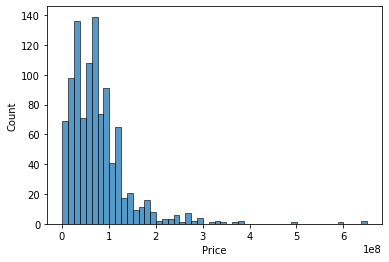

In [18]:
#Some exploratory data analysis
# 1. Distribution of price
len(data.columns)
sns.histplot(data=data, x='Price')
plt.show()

                                  Price  Bedrooms  Bathrooms    School  \
Price                          1.000000  0.449081   0.414375 -0.085924   
Bedrooms                       0.449081  1.000000   0.640845 -0.050726   
Bathrooms                      0.414375  0.640845   1.000000  0.005996   
School                        -0.085924 -0.050726   0.005996  1.000000   
Bus Stop                      -0.141390 -0.054206  -0.003827  0.750585   
Hospital                      -0.075754 -0.044305   0.012260  0.921838   
Balcony                        0.127972  0.202794   0.285977  0.248341   
Parking                        0.000249  0.016691   0.072384  0.504025   
Staff Quarters                 0.128751  0.077870   0.132757  0.429138   
Electric Fence                 0.102293  0.054763   0.164343  0.358584   
Garden                         0.131716  0.092937   0.130235  0.313703   
Furnished                     -0.024037  0.047271   0.039796  0.049524   
En Suite                       0.04951

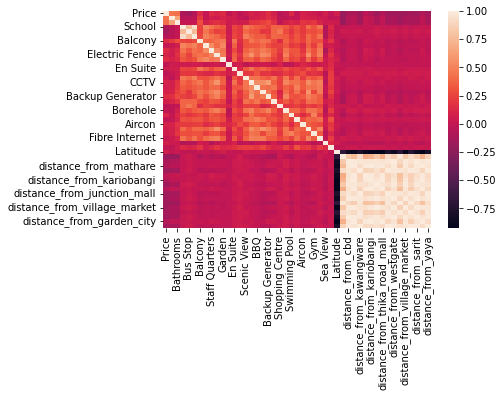

In [19]:
# 2. Correlation between features
corr_matrix = data.corr(method='pearson')
print(corr_matrix)
sns.heatmap(data=corr_matrix)
plt.show()

In [31]:
#Isolate columns that contain categorical versus numeric data
categorical_cols = list(data.loc[:,'School':'Service Charge Included'].columns)
print(categorical_cols)
numeric_cols = [col for col in data.columns if (col not in categorical_cols) & (col not in 'Price')]
print(numeric_cols)

['School', 'Bus Stop', 'Hospital', 'Balcony', 'Parking', 'Staff Quarters', 'Electric Fence', 'Garden', 'Furnished', 'En Suite', 'Serviced', 'Scenic View', 'CCTV', 'BBQ', 'Walk In Closet', 'Backup Generator', 'Golf Course', 'Shopping Centre', 'Borehole', 'Swimming Pool', 'Wheelchair Access', 'Aircon', 'Alarm', 'Gym', 'Fibre Internet', 'Sea View', 'Service Charge Included']
['Bedrooms', 'Bathrooms', 'Latitude', 'Longitude', 'distance_from_cbd', 'distance_from_mathare', 'distance_from_kawangware', 'distance_from_kayole', 'distance_from_kariobangi', 'distance_from_two_rivers', 'distance_from_thika_road_mall', 'distance_from_junction_mall', 'distance_from_westgate', 'distance_from_hub', 'distance_from_village_market', 'distance_from_galleria', 'distance_from_sarit', 'distance_from_garden_city', 'distance_from_yaya']


In [32]:
# Check for outliers using z-score to inform scaling technique choice
z_scores = []
for col in data.columns:
    try: 
        z_score = (data[col] - data[col].mean())/data[col].std()
        z_scores.append(z_score)
    except TypeError:
        pass

#Print out columns with outliers
for z_score in z_scores:
    if (z_score>3).any() or (z_score<-3).any():
        print(f'{z_score.name} has outliers')
    else:
        pass

Price has outliers
Bedrooms has outliers
Bathrooms has outliers
Furnished has outliers
Serviced has outliers
Sea View has outliers
Latitude has outliers
Longitude has outliers
distance_from_cbd has outliers
distance_from_mathare has outliers
distance_from_kawangware has outliers
distance_from_kayole has outliers
distance_from_kariobangi has outliers
distance_from_two_rivers has outliers
distance_from_thika_road_mall has outliers
distance_from_junction_mall has outliers
distance_from_westgate has outliers
distance_from_hub has outliers
distance_from_village_market has outliers
distance_from_galleria has outliers
distance_from_sarit has outliers
distance_from_garden_city has outliers
distance_from_yaya has outliers


In [33]:
#Call and fit scaler that works well with outliers - can use StandardScaler() or MaxAbsScaler()
#MaxAbsScaler() yields slightly better model performance
scaler = MaxAbsScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data

,Price,Bedrooms,Bathrooms,School,Bus Stop,Hospital,Balcony,Parking,Staff Quarters,Electric Fence,...,distance_from_two_rivers,distance_from_thika_road_mall,distance_from_junction_mall,distance_from_westgate,distance_from_hub,distance_from_village_market,distance_from_galleria,distance_from_sarit,distance_from_garden_city,distance_from_yaya
0,25000000.0,0.4,0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.041426,0.071345,0.003736,0.024876,0.033186,0.035759,0.025255,0.023150,0.063408,0.010249
1,30000000.0,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040919,0.076222,0.081900,0.064546,0.095975,0.051506,0.105598,0.066280,0.076071,0.080380
2,29000000.0,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040919,0.076222,0.081900,0.064546,0.095975,0.051506,0.105598,0.066280,0.076071,0.080380
3,30000000.0,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040919,0.076222,0.081900,0.064546,0.095975,0.051506,0.105598,0.066280,0.076071,0.080380
4,28000000.0,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040919,0.076222,0.081900,0.064546,0.095975,0.051506,0.105598,0.066280,0.076071,0.080380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,95000000.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010100,0.037343,0.048168,0.021149,0.073765,0.008321,0.068059,0.023183,0.032922,0.040285
1009,150000000.0,0.7,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025801,0.060199,0.019452,0.013197,0.045179,0.020728,0.041026,0.012438,0.052991,0.016218
1010,27000000.0,0.4,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028319,0.036528,0.037830,0.012369,0.067028,0.018423,0.052135,0.012980,0.028492,0.026043
1011,50000000.0,0.4,0.4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.071469,0.110649,0.036290,0.062626,0.006890,0.069973,0.040033,0.061274,0.103017,0.049503


In [34]:
# Split dataframe into training and test sets (80%:20%)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)
train_df

,Price,Bedrooms,Bathrooms,School,Bus Stop,Hospital,Balcony,Parking,Staff Quarters,Electric Fence,...,distance_from_two_rivers,distance_from_thika_road_mall,distance_from_junction_mall,distance_from_westgate,distance_from_hub,distance_from_village_market,distance_from_galleria,distance_from_sarit,distance_from_garden_city,distance_from_yaya
479,49000000.0,0.5,0.3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.026220,0.054596,0.021397,0.007432,0.049528,0.018769,0.040652,0.006043,0.047052,0.013510
47,80000000.0,0.5,0.6,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.010100,0.037343,0.048168,0.021149,0.073765,0.008321,0.068059,0.023183,0.032922,0.040285
529,58000000.0,0.3,0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.026804,0.022961,0.064973,0.036512,0.091586,0.026196,0.083160,0.038442,0.022668,0.055492
812,21945000.0,0.4,0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.021893,0.035288,0.066024,0.039091,0.090385,0.026033,0.086380,0.041142,0.035152,0.058411
19,75000000.0,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.071469,0.110649,0.036290,0.062626,0.006890,0.069973,0.040033,0.061274,0.103017,0.049503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,35000000.0,0.4,0.3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.027391,0.051212,0.023665,0.005521,0.052594,0.018786,0.041070,0.003517,0.043444,0.013541
72,110000000.0,0.6,0.8,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.033635,0.063226,0.012335,0.016373,0.040921,0.027346,0.032576,0.014724,0.055455,0.008284
908,40000000.0,0.7,0.7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.071469,0.110649,0.036290,0.062626,0.006890,0.069973,0.040033,0.061274,0.103017,0.049503
235,51000000.0,0.5,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033635,0.063226,0.012335,0.016373,0.040921,0.027346,0.032576,0.014724,0.055455,0.008284


In [35]:
#Define the X variable for both train and test sets
train_X = train_df[numeric_cols+categorical_cols]
test_X = test_df[numeric_cols+categorical_cols]

#Define the Y or target variable
train_y = train_df['Price']
test_y = test_df['Price']

#Check shapes of the inputs and targets
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(810, 46)
(203, 46)
(810,)
(203,)


In [49]:
def random_forest(X, y, X_test, y_test):
    """
    Function to initialize and fit a random forest model to train data,
    make predictions of X, calculate and print RMSE & R^2.
    """
    RF_model = RandomForestRegressor(n_estimators=142, max_depth=39, max_leaf_nodes=29, 
                                     random_state=1, bootstrap=False, max_features='log2',
                                     n_jobs=-1)
    RF_model.fit(X, y)
    train_prediction = RF_model.predict(X)
    test_prediction = RF_model.predict(X_test)
    train_RMSE = mean_squared_error(y, train_prediction)**(0.5)
    test_RMSE = mean_squared_error(y_test, test_prediction)**(0.5)
    train_r2 = RF_model.score(X, y)
    test_r2 = RF_model.score(X_test, y_test)
    
    print(f'train_RMSE: {train_RMSE:.2f}', f'test_RMSE: {test_RMSE:.2f}')
    print(f'train_r2: {train_r2:.2f}', f'test_r2: {test_r2:.2f}')

#### Model Performance Without Feature Engineering

In [50]:
no_engineering_data = data.loc[:,'Price':'Service Charge Included']
train_no_engineering, test_no_engineering = train_test_split(no_engineering_data, test_size=0.2, random_state=1)
no_engineering_train_X = train_no_engineering.iloc[:,1:]
no_engineering_test_X = test_no_engineering.iloc[:,1:]

no_engineering_train_y = train_no_engineering['Price']
no_engineering_test_y = test_no_engineering['Price']

random_forest(no_engineering_train_X, no_engineering_train_y, no_engineering_test_X, no_engineering_test_y)

train_RMSE: 43806672.72 test_RMSE: 70138620.76
train_r2: 0.52 test_r2: 0.15


Test accuracy was 15% using raw data; i.e., before considering effects of feature engineering.

#### Model Performance With Feature Engineering

In [51]:
#Initialize and fit a random forest model to the training data
random_forest(train_X, train_y, test_X, test_y)

train_RMSE: 34573523.32 test_RMSE: 65098139.96
train_r2: 0.70 test_r2: 0.27


The model achieved a 27% test accuracy on account of missing important features, such as size of property. However, feature engineering improved the model performance from 15% to 27%, an 80% improvement.

#### Model Performance after using Fewer Features

Index(['Bedrooms', 'distance_from_village_market', 'distance_from_kawangware',
       'distance_from_hub', 'Garden', 'distance_from_two_rivers', 'Bathrooms',
       'Swimming Pool', 'distance_from_yaya', 'Longitude', 'distance_from_cbd',
       'distance_from_mathare', 'distance_from_kayole', 'Staff Quarters',
       'Aircon', 'distance_from_galleria', 'Scenic View',
       'distance_from_junction_mall', 'distance_from_kariobangi',
       'distance_from_garden_city', 'School', 'Parking',
       'distance_from_thika_road_mall'],
      dtype='object')


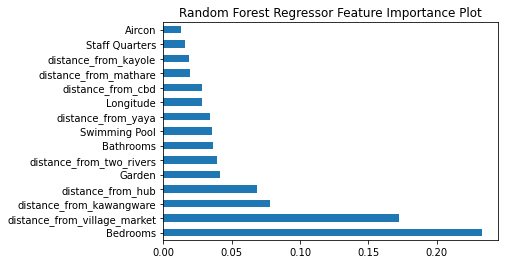

In [37]:
#Create a pandas series with feature importances from the random forest model
feature_importance_sr = pd.Series(RF_model.feature_importances_, index = train_X.columns)
print(feature_importance_sr.nlargest(23).index)

#Plot some of the most important features
feature_importance_sr.nlargest(n=15).plot(kind='barh')
plt.title('Random Forest Regressor Feature Importance Plot')
plt.show()

In [38]:
#Train and test a model using 25% top features
train_X_redacted = train_X[['Bedrooms', 'distance_from_village_market', 'Bathrooms',
                           'distance_from_kawangware', 'Swimming Pool',
                           'distance_from_junction_mall', 'distance_from_mathare', 'Garden',
                           'distance_from_two_rivers', 'distance_from_hub', 'distance_from_cbd',
                           'distance_from_yaya', 'Longitude', 'Latitude'
                           ]]

test_X_redacted = test_X[['Bedrooms', 'distance_from_village_market', 'Bathrooms',
                           'distance_from_kawangware', 'Swimming Pool',
                           'distance_from_junction_mall', 'distance_from_mathare', 'Garden',
                           'distance_from_two_rivers', 'distance_from_hub', 'distance_from_cbd',
                           'distance_from_yaya', 'Longitude', 'Latitude'
                           ]]
test_X_redacted

,Bedrooms,distance_from_village_market,Bathrooms,distance_from_kawangware,Swimming Pool,distance_from_junction_mall,distance_from_mathare,Garden,distance_from_two_rivers,distance_from_hub,distance_from_cbd,distance_from_yaya,Longitude,Latitude
918,0.4,0.007650,0.5,0.035608,0.0,0.040892,0.039280,1.0,0.004776,0.064285,0.035017,0.035620,0.962706,-0.446741
618,0.3,0.026196,0.3,0.062142,0.0,0.064973,0.032125,1.0,0.026804,0.091586,0.044104,0.055492,0.964195,-0.438619
293,0.5,0.069973,0.8,0.034533,0.0,0.036290,0.088645,0.0,0.071469,0.006890,0.068555,0.049503,0.960048,-0.482072
507,0.3,0.027279,0.2,0.014296,0.0,0.013022,0.039628,1.0,0.034080,0.042177,0.020936,0.006536,0.962438,-0.468847
973,0.5,0.013176,0.5,0.024650,1.0,0.026834,0.032047,1.0,0.021052,0.054218,0.020129,0.019020,0.962786,-0.459326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0.4,0.030265,0.2,0.005904,0.0,0.011827,0.048999,1.0,0.034344,0.035604,0.031285,0.015704,0.961911,-0.466483
1007,0.4,0.009321,0.3,0.026881,0.0,0.030510,0.034265,1.0,0.015989,0.056438,0.024899,0.024015,0.962721,-0.455430
426,0.5,0.012237,0.5,0.027716,0.0,0.029187,0.028473,1.0,0.021262,0.057149,0.017845,0.020118,0.962974,-0.459249
452,0.4,0.070854,0.4,0.039651,1.0,0.032771,0.075370,0.0,0.076832,0.029818,0.055143,0.040251,0.961547,-0.499361


In [52]:
#Random forest model using only 25% of the top features
random_forest(train_X_redacted, train_y, test_X_redacted, test_y)

train_RMSE: 34362938.81 test_RMSE: 60974124.80
train_r2: 0.70 test_r2: 0.36


Model performance using 14 features (circa 25% of all features) improves model performance from 27% (post-FE) to 36%, or by 33%. Overall model performance from raw inputs to redacted features has improved by 140%; from 15% to 36%.

#### Will a Random Search Yield Better Performance?

In [54]:
warnings.simplefilter(action='ignore')
model = RandomForestRegressor(bootstrap=False, max_features='log2', random_state=1, n_jobs=-1)
    
param_grid = {'n_estimators': np.arange(50,1000), 'max_depth': np.arange(4,200), 'max_leaf_nodes': np.arange(2,200)}

search = HalvingRandomSearchCV(estimator=model, param_distributions=param_grid, random_state=1)
search.fit(train_X_redacted, train_y)
print(f'best_params: {search.best_params_}', f'best_estimator: {search.best_estimator_}',
      f'best_score: {search.best_score_}')

best_params: {'n_estimators': 128, 'max_leaf_nodes': 50, 'max_depth': 76} best_estimator: RandomForestRegressor(bootstrap=False, max_depth=76, max_features='log2',
                      max_leaf_nodes=50, n_estimators=128, n_jobs=-1,
                      random_state=1) best_score: 0.3667421500745838


The search yields a 0.67% improvement in redacted random forest model at the expense of more memory usage (higher depth and leaf nodes). Prudent to go with previous model. 

#### Saving Model for Future Use

In [57]:
#Save model
RF_model_final = RandomForestRegressor(n_estimators = 142, max_depth=39, max_leaf_nodes=29,
                                          bootstrap=False, max_features='log2', random_state=1, 
                                          n_jobs=-1)
RF_model_final.fit(train_X_redacted, train_y)

pickle_model = 'house_price_prediction.pkl'

#Dump model
with open(pickle_model, 'wb') as file:
    pickle.dump(RF_model_final, file)
    
# Load model
with open(pickle_model, 'rb') as file:
    RF_model = pickle.load(file)

RF_model

RandomForestRegressor(bootstrap=False, max_depth=39, max_features='log2',
                      max_leaf_nodes=29, n_estimators=142, n_jobs=-1,
                      random_state=1)

#### Inserting and Predicting New Inputs 

In [58]:
#Predict new inputs using the features from the redacted random forest regressor 
binary_dict = {'yes': 1, 'no': 0}
def house_price_predictor():
    """
    Function to consume new inputs, create new information from those inputs, and 
    predict the house price using the previously fitted random forest model. 
    Returns the predicted house value in Ksh. 
    """
    bedrooms = float(input('Number of bedrooms: '))
    bathrooms = float(input('Number of bathrooms: '))
    swimming_pool = str(input("Is there a swimming pool? Enter 'yes' or 'no' ")).lower()
    garden = str(input("Is there a garden? Enter 'yes' or 'no' ")).lower()
    location = str(input('Enter precise location of the property: '))
    new_house_dict = {'Bedrooms': bedrooms, 'Bathrooms': bathrooms, 
                      'Swimming Pool': swimming_pool, 'Garden': garden,
                      'Location': location}
    df = pd.DataFrame(new_house_dict, index=[0])
    df['Swimming Pool'] = df['Swimming Pool'].map(binary_dict)
    df['Garden'] = df['Garden'].map(binary_dict)
    df['Latitude'] = get_location_coordinates(location)[0]
    df['Longitude'] = get_location_coordinates(location)[1]
    df['Coordinates'] = list(zip(df.Latitude, df.Longitude))
    df['distance_from_village_market'] = get_distance(df['Coordinates'], village_market_coordinates)
    df['distance_from_kawangware'] = get_distance(df['Coordinates'], kawangware_coordinates)
    df['distance_from_yaya'] = get_distance(df['Coordinates'], yaya_coordinates)
    df['distance_from_two_rivers'] = get_distance(df['Coordinates'], two_rivers_coordinates)
    df['distance_from_mathare'] = get_distance(df['Coordinates'], mathare_coordinates)
    df['distance_from_cbd'] = get_distance(df['Coordinates'], CBD_coordinates)
    df['distance_from_junction_mall'] = get_distance(df['Coordinates'], junction_mall_coordinates)
    df['distance_from_hub'] = get_distance(df['Coordinates'], hub_coordinates)
    df = df.drop(columns = ['Location', 'Coordinates'])
    numeric_cols = ['Bedrooms', 'Bathrooms', 'Latitude', 'Longitude', 'distance_from_village_market',
                   'distance_from_kawangware', 'distance_from_yaya', 'distance_from_two_rivers',
                   'distance_from_mathare', 'distance_from_cbd', 'distance_from_junction_mall', 
                   'distance_from_hub']
    scaler.fit(df[numeric_cols])
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    prediction = RF_model_redacted.predict(df)
    return np.round(prediction, decimals=0)
 
house_price_predictor()

Number of bedrooms: 4
Number of bathrooms: 4
Is there a swimming pool? Enter 'yes' or 'no' no
Is there a garden? Enter 'yes' or 'no' yes
Enter precise location of the property: Gateway Mall, Syokimau


array([32769795.])

Model predicts a price of Kes. 32.8 million against a listed price of Kes. 17.0 million